# Using GAN to Generate MNIST-like images

**Description:** A Keras-based GAN model to train on MNIST data and produce fake digit images.

In [1]:
import tensorflow as tf
import keras
import numpy as np

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Keras GAN Model

Let's consider:

- A generator network meant to generate 28x28x1 images.
- A discriminator network meant to classify 28x28x1 images into two classes ("fake" and
"real").
- One optimizer for each(Adan optimizer).
- A loss function to train the discriminator(Binary Cross Entropy).


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
log_dir = "logs/fit"  # Choose the directory name as you like
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

Here's a feature-complete GAN class, overriding `compile()` to use its own signature,
and implementing the entire GAN algorithm in `train_step`:

In [4]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }


Let's test-drive it:

In [5]:
!rm -rf logs

In [6]:
# %tensorboard --logdir logs/fit

In [7]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
#gan.fit(dataset.take(100), epochs=1)
gan.fit(dataset, epochs=40,  callbacks=[tensorboard_callback])

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/40
1094/1094 [==============================] - 39s 26ms/step - d_loss: 0.4634 - g_loss: 1.4113
Epoch 2/40
1094/1094 [==============================] - 29s 27ms/step - d_loss: 0.3111 - g_loss: 2.1239
Epoch 3/40
1094/1094 [==============================] - 30s 27ms/step - d_loss: 0.4809 - g_loss: 1.6984
Epoch 4/40
1094/1094 [==============================] - 29s 27ms/step - d_loss: 0.6699 - g_loss: 0.8655
Epoch 5/40
1094/1094 [==============================] - 29s 27ms/step - d_loss: 0.6671 - g_loss: 0.8508
Epoch 6/40
1094/1094 [==============================] - 29s 27ms/step - d_loss: 0.6512 - g_loss: 0.8728
Epoch 7/40
1094/1094 [==============================] - 29s 26ms/step - d_loss: 0.6379 - g_loss: 0.8826
Epoch 8/40
1094/1094 [==============================] - 30s 27ms/step - d_loss: 0.6175 - g_loss: 0.9392
Epoch 9/40
1094/1094 [==============================] - 30s 27ms/step - d_loss: 0.5966 - g_loss: 0.9857

The ideas behind deep learning are simple, so why should their implementation be painful?

# Generate Image from Trained GAN Model

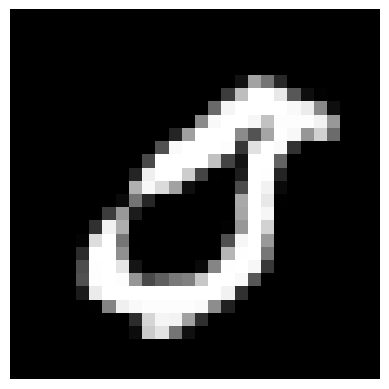

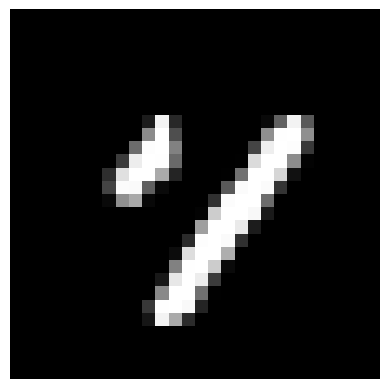

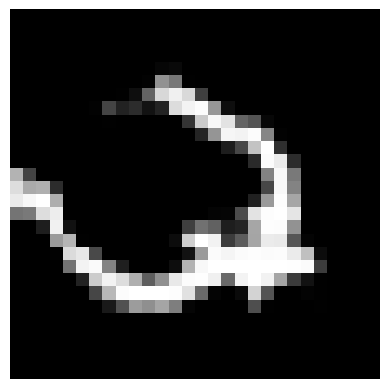

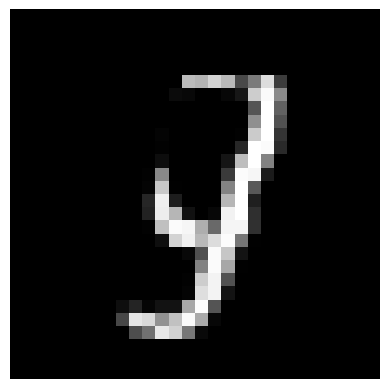

In [8]:
# Sample random points in the latent space
random_latent_vectors = tf.random.normal(shape=(4, 128))
res = gan.generator(random_latent_vectors)
# Get the first image from the array (assuming there's only one)
import matplotlib.pyplot as plt
for i in range(4):
  image = res[i, :, :, 0]

  # Display the image using matplotlib
  plt.imshow(image, cmap='gray')  # 'gray' colormap for black and white images
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()


In [9]:
type(res[0])

tensorflow.python.framework.ops.EagerTensor

# Save Model

In [10]:
from tensorflow.keras.models import save_model
# Save the model to a file
save_model(gan.generator, 'mnist_GAN_40epochs.h5')

# Load model

In [11]:
from tensorflow.keras.models import load_model

loaded_model = load_model('mnist_GAN_40epochs.h5')


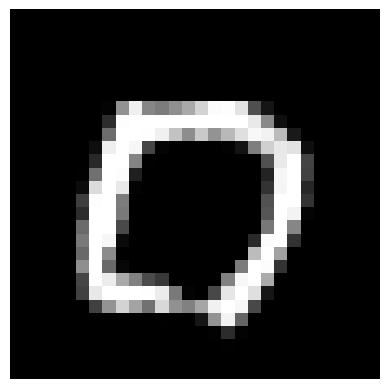

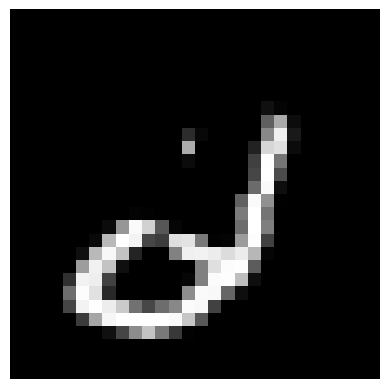

In [12]:
# Sample random points in the latent space
random_latent_vectors = tf.random.normal(shape=(2, 128))
res = loaded_model(random_latent_vectors)
# Get the first image from the array (assuming there's only one)
import matplotlib.pyplot as plt
for i in range(2):
  image = res[i, :, :, 0]

  # Display the image using matplotlib
  plt.imshow(image, cmap='gray')  # 'gray' colormap for black and white images
  plt.axis('off')  # Turn off axis labels and ticks
  plt.show()